# An example pipeline
Using the created classes in the data_utils and utils, we can create fairly efficient pipeline, without running much code.
About the design choices, we chose a pure tensorflow approach using tf datasets, instead of keras imagedatagenerator, since it is quite a bit faster: https://www.tensorflow.org/tutorials/load_data/images   

The following cells will show an example of how to use each function, hopefully also explaining the thought behind the pipeline: avoid repeating alot of routine code, whilst providing flexibility.
   
**Note**: We assume that you have tiled the data into 16x128x128 images, that is located in the data/train folder. See the tiling notebook for more information.
   
**Note2**: Some of this is still work in progress. Ideally, neural networks are created in their own separate files, and then imported and wrapped using the Network class defined in the models folder. Since this is not finished, we will not use it for now in this example. 

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
%load_ext tensorboard

# load tensorflow dependencies
import tensorflow as tf
from classification_models.tfkeras import Classifiers
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.metrics import CohenKappa
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from tensorflow_addons.layers import GroupNormalization


# 16 bit precision computing
from tensorflow.keras.mixed_precision import experimental as mixed_precision
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import skimage.io
import sys
from functools import partial

from sklearn.model_selection import StratifiedKFold
import time


sys.path.insert(0,'..')
from model.layers import GeneralizedMeanPooling2D

# custom packages
from preprocessing.utils.data_loader import PandasDataLoader
from preprocessing.generators import TiffGenerator, TiffFromCoords
from preprocessing.utils.mat_transforms import tf_tile2mat, tf_tile2square
from utils.utils import set_gpu_memory, seed_all

from model.network import Network

# Augmentation packages

# custom stain augmentation
from preprocessing.augmentations import StainAugment

import albumentations as A
from albumentations import (
    Flip, ShiftScaleRotate, RandomRotate90,
    ShiftScaleRotate, Blur, OpticalDistortion, RandomBrightnessContrast, 
    OneOf, Compose, RandomScale, ElasticTransform, GaussNoise, GaussianBlur,
    RandomBrightness, RandomContrast
)


2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


## Setup

In [3]:
seed_all(20)
DATA_DIR = Path('../data/')

# control for the gpu memory, and number of used gpu's
set_gpu_memory(device_type='GPU')
# see the utils functions which seeds are set
# tensorflow ops still have to be seeded manually...
seed_all()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Compute dtype: float16
Variable dtype: float32


## Today:
~~create train/val split~~  
Generalize train/val to KFold training   
~~create a basic data augmentation ~~ 
~~Image preprocessing~~
~~Alter network top with more layers~~   
~~Make a second model that chains two models~~

## Directory processing and declaring constants

In [4]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train_images'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/masks'  # Path to the masks

# ------------------
# Data constants
# ------------------
NFOLDS = 4  # number of folds to use for training/validation (cross validation)
SEED=5  # the seed TODO: REPLACE THIS WITH A FUNCTION THAT SEEDS EVERYTHING WITH SEED
TRAIN_FOLD=0  # select the first fold for training/validation

# ------------------
# Network parameters
# ------------------
# some of these parameters might disappear in a future release
SZ = 240  # width and heigth of the image
NUM_CLASSES = 6 
BATCH_SIZE = 3
NUM_EPOCHS = 15  
NUM_TILES = 32 # this number cannot be changed freely in the png tile generator
LEARNING_RATE = 1e-5
TILE_LEVEL = 1

tile_params = {'N': NUM_TILES, 'sz': SZ}

## Create folds for K fold validation
The class below returns a pandas dataframe with an added 'split' column. The split column contains the fold index, which can in turn be used for cross validation.

Notice also that there are skip_csv and skip_list arguments. The skip_csv arg is a path to a file with image id's of slides that should/could be skipped, since they are faulty due to pen mark. The skip_list argument provides an extra handle to filter out only several reasons. For example, if we only want to filter out faulty images with the reason "no masks", we can do that by adding it to the skip_list.

In [5]:
# an example: loading the skip dataframe and listing the possible reasons
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=[])

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_sample(NFOLDS, SEED)

# we can create training/validation splits from the fold column
train_df = fold_df[fold_df['split'] != TRAIN_FOLD]
valid_df = fold_df[fold_df['split'] == TRAIN_FOLD]

display(train_df)
display(valid_df)

possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
number of duplicates in the skip df: (13, 2)
Training dataframe after filtering: (9954, 4)
Number of rows removed by filter: 662
********************


,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,2
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1
...,...,...,...,...,...
10622,ffcd99c47e57ad2934dc6bbf5edf6675,karolinska,0,0+0,2
10624,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,2
10625,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,2
10626,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,3


,image_id,data_provider,isup_grade,gleason_score,split
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,0
10,00412139e6b04d1e1cee8421f38f6e90,karolinska,0,0+0,0
13,004f6b3a66189b4e88b6a01ba19d7d31,karolinska,1,3+3,0
29,00c15b23b30a5ba061358d9641118904,radboud,5,4+5,0
...,...,...,...,...,...
10596,ff339e5fa7be6af83c1b43796092398f,karolinska,4,4+4,0
10603,ff596d5292ab979e9ba7291d0743b3fb,karolinska,0,0+0,0
10618,ffc005d56a21efbd034425623f596984,karolinska,2,3+4,0
10621,ffcbb41626c9267c5c20c4804bd5639a,radboud,4,3+5,0


In [6]:
FOLDED_NUM_TRAIN_IMAGES = train_df.shape[0]
FOLDED_NUM_VALID_IMAGES = valid_df.shape[0]
STEPS_PER_EPOCH = FOLDED_NUM_TRAIN_IMAGES // BATCH_SIZE  # Calculate the steps for keras
VALIDATION_STEPS = FOLDED_NUM_VALID_IMAGES // BATCH_SIZE  # Calculate the same for validation


print('*'*20)
print('Notebook info')
print('Training data : {}'.format(FOLDED_NUM_TRAIN_IMAGES))
print('Validing data : {}'.format(FOLDED_NUM_VALID_IMAGES))
print('Categorical classes : {}'.format(NUM_CLASSES))
print('Training image size : {}'.format(SZ))
print('Training epochs : {}'.format(NUM_EPOCHS))
print('*'*20)

********************
Notebook info
Training data : 7465
Validing data : 2489
Categorical classes : 6
Training image size : 240
Training epochs : 15
********************


## Generate dataset
Since we are working with the tf dataset api, we need to pair the actual images with their id's, and convert them to a tf dataset. This is all done for us under the hood in the PNGTileGenerator class
   
**Note:** Tensorflow was at it again during debugging. I wanted to use a tf.vectorized_map function which is more efficient, but this gave low level tensorflow errors. As a result, I had to use map_fn which uses up more resources.

## augmentation functions
Currently only some color changes. The histomicstk package is really slow though. Probably due to masking and changing to H&E colour space.

In [7]:
R = Compose([RandomRotate90(p=0.5), Flip(p=0.5)])
S = Compose([RandomScale(scale_limit=0.1, interpolation=1, p=0.5)])
C = Compose([StainAugment(p=0.9)])
E = Compose([ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5)])


BRIGHT = Compose([RandomBrightness(limit=0.12, p=0.5)])
CONTR = Compose([RandomContrast(limit=0.12, p=0.5)])

B = Compose([GaussianBlur(blur_limit=5, p=0.5)])
G = Compose([GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)])



In [8]:
def aug_routine(image):
    R = Compose([RandomRotate90(p=0.5), Flip(p=0.5)])
    #S = Compose([RandomScale(scale_limit=0.1, interpolation=1, p=0.5)])
    C = Compose([StainAugment(p=0.9)])
    #E = Compose([ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=0.5)])

    BRIGHT = Compose([RandomBrightness(limit=0.10, p=0.5)])
    CONTR = Compose([RandomContrast(limit=0.10, p=0.5)])    
    
    B = Compose([GaussianBlur(blur_limit=5, p=0.5)])
    G = Compose([GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)])
    augment = Compose([C], p=0.9)
    aug_op = augment(image=image)
    image = aug_op['image']
    return image

def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x, seed=1)
    x = tf.image.random_flip_up_down(x, seed=1)

    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, 
                          tf.random.uniform(shape=[], 
                                               minval=0, 
                                               maxval=4, 
                                               dtype=tf.int32, 
                                               seed=1))


augments = [flip, rotate]

In [9]:
coords = np.load('../coordinates/1-36-240-255.npy',allow_pickle=True)

tilemat = partial(tf_tile2mat, row=6, col=6)

data = TiffFromCoords(coords = coords,
                             df=train_df, 
                             img_dir=IMG_DIR, 
                             batch_size=BATCH_SIZE, 
                             aug_func=None,
                             tf_aug_list = [],
                             one_hot=False,
                             img_transform_func=tilemat)

# do not use augmentation for the val_data, if aug_func is empty (None default), then no augmentation is used.
val_data = TiffFromCoords(coords = coords,
                         df=valid_df, 
                         img_dir=IMG_DIR, 
                         batch_size=BATCH_SIZE, 
                         aug_func=None,
                         one_hot=False,
                         img_transform_func=tilemat)


'''
data = TiffGenerator(df=train_df, 
                     img_dir=IMG_DIR, 
                     tiff_level=TILE_LEVEL, 
                     batch_size=BATCH_SIZE, 
                     aug_func=None,
                     tile_params=tile_params,
                     one_hot=False)

# do not use augmentation for the val_data, if aug_func is empty (None default), then no augmentation is used.
val_data = TiffGenerator(df=valid_df, 
                         img_dir=IMG_DIR, 
                         tiff_level=TILE_LEVEL, 
                         batch_size=BATCH_SIZE, 
                         aug_func=None,
                         tile_params=tile_params,
                         one_hot=False)
'''

'\ndata = TiffGenerator(df=train_df, \n                     img_dir=IMG_DIR, \n                     tiff_level=TILE_LEVEL, \n                     batch_size=BATCH_SIZE, \n                     aug_func=None,\n                     tile_params=tile_params,\n                     one_hot=False)\n\n# do not use augmentation for the val_data, if aug_func is empty (None default), then no augmentation is used.\nval_data = TiffGenerator(df=valid_df, \n                         img_dir=IMG_DIR, \n                         tiff_level=TILE_LEVEL, \n                         batch_size=BATCH_SIZE, \n                         aug_func=None,\n                         tile_params=tile_params,\n                         one_hot=False)\n'

The display_batch function displays the data training batch with augmentations. Since the val_data was initialized without any aug func, it has no augmentation routine

In [12]:
for x in data(mode='validation').take(1):
    pass

<tf.Tensor: shape=(1440, 1440, 3), dtype=float32, numpy=
array([[[0.15686268, 0.61568624, 0.29019606],
        [0.16078424, 0.5568627 , 0.25490195],
        [0.18823522, 0.5686274 , 0.27843136],
        ...,
        [0.3333333 , 0.5568627 , 0.2745098 ],
        [0.2980392 , 0.654902  , 0.3215686 ],
        [0.3843137 , 0.6823529 , 0.38823527]],

       [[0.19999993, 0.5921568 , 0.32941175],
        [0.22352934, 0.67058825, 0.31764704],
        [0.23137248, 0.6980392 , 0.3333333 ],
        ...,
        [0.4352941 , 0.7254902 , 0.43137252],
        [0.44313723, 0.7176471 , 0.39215684],
        [0.4705882 , 0.65098035, 0.35686272]],

       [[0.2156862 , 0.62745094, 0.32549018],
        [0.27058822, 0.6627451 , 0.3490196 ],
        [0.34117645, 0.6823529 , 0.3490196 ],
        ...,
        [0.6392157 , 0.8156863 , 0.5058823 ],
        [0.5803921 , 0.7882353 , 0.45098037],
        [0.39215684, 0.7254902 , 0.4078431 ]],

       ...,

       [[0.10980386, 0.12549013, 0.09803915],
        [0.

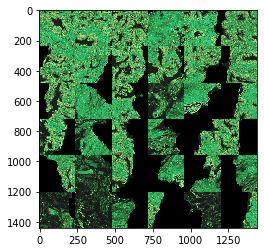

In [14]:
plt.imshow(x[0][0,...])
x[0][0,...]

done reshaping image (3, 1440, 1440, 3)


IndexError: index 3 is out of bounds for axis 0 with size 3

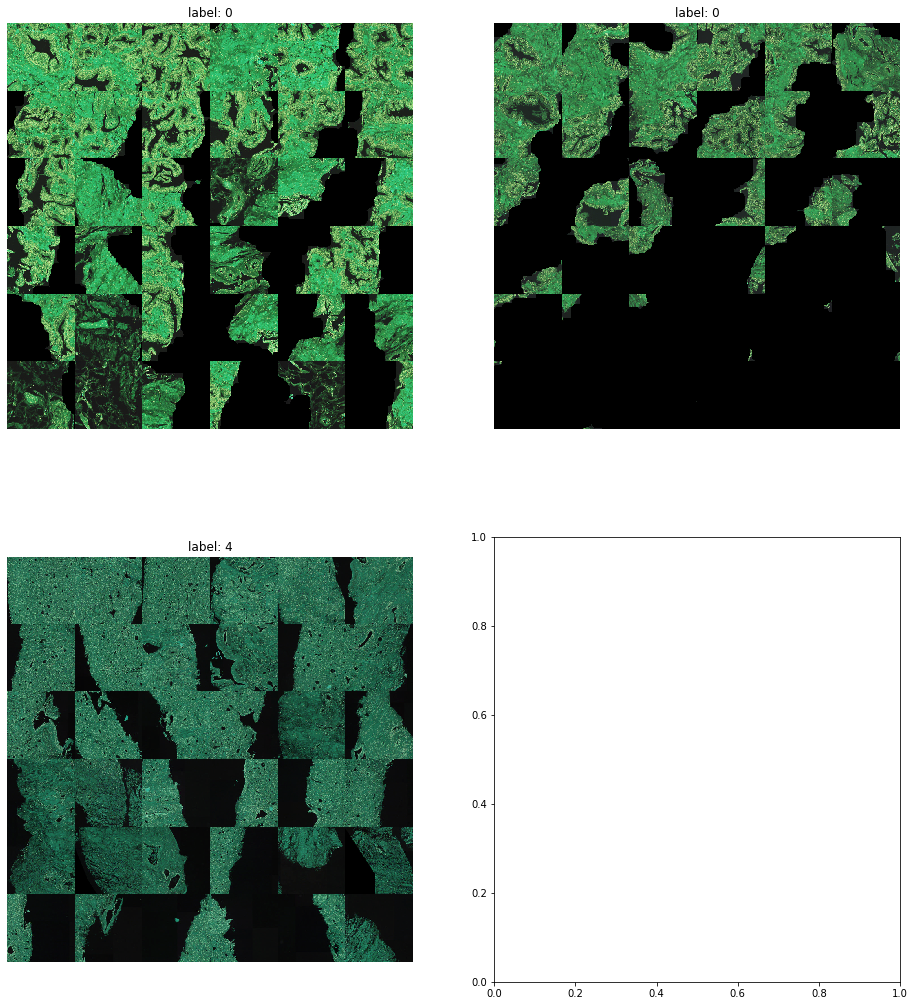

In [15]:
data.display_batch(plot_grid=(2,2), rows=8, cols=4)

done reshaping image (16, 1440, 1440, 3)
done plotting


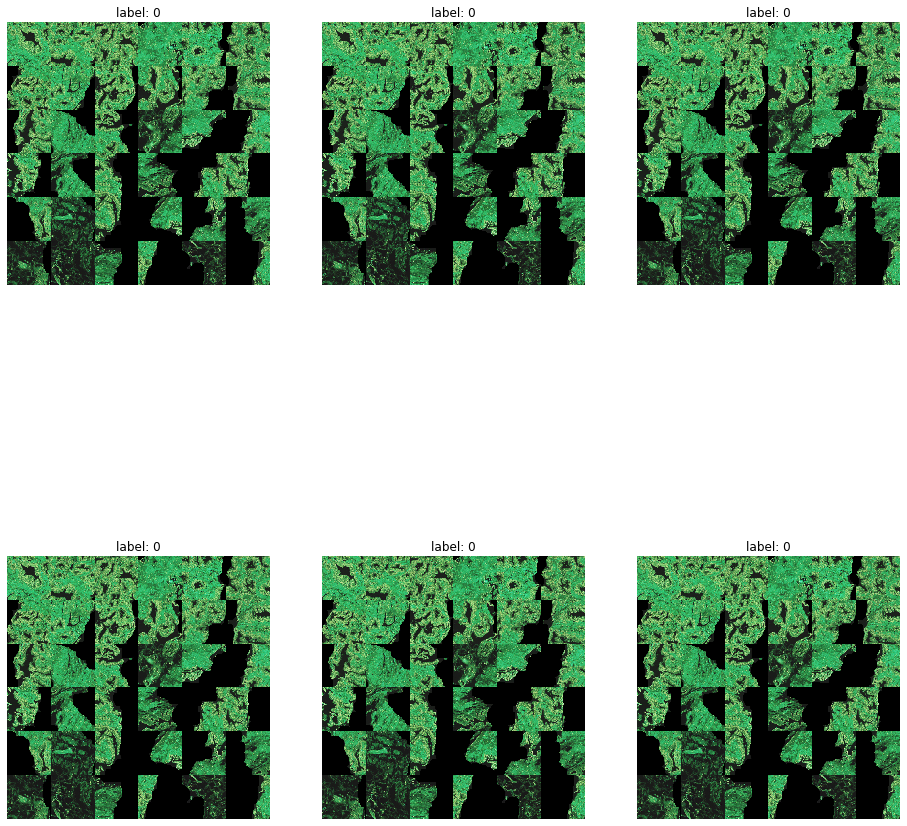

In [17]:
data.display_augmentation(plot_grid=(2,3), rows=1, cols=3)

shape of batch, done batch creating (6, 16, 256, 256, 3)
done reshaping image (6, 1024, 1024, 3)
done plotting


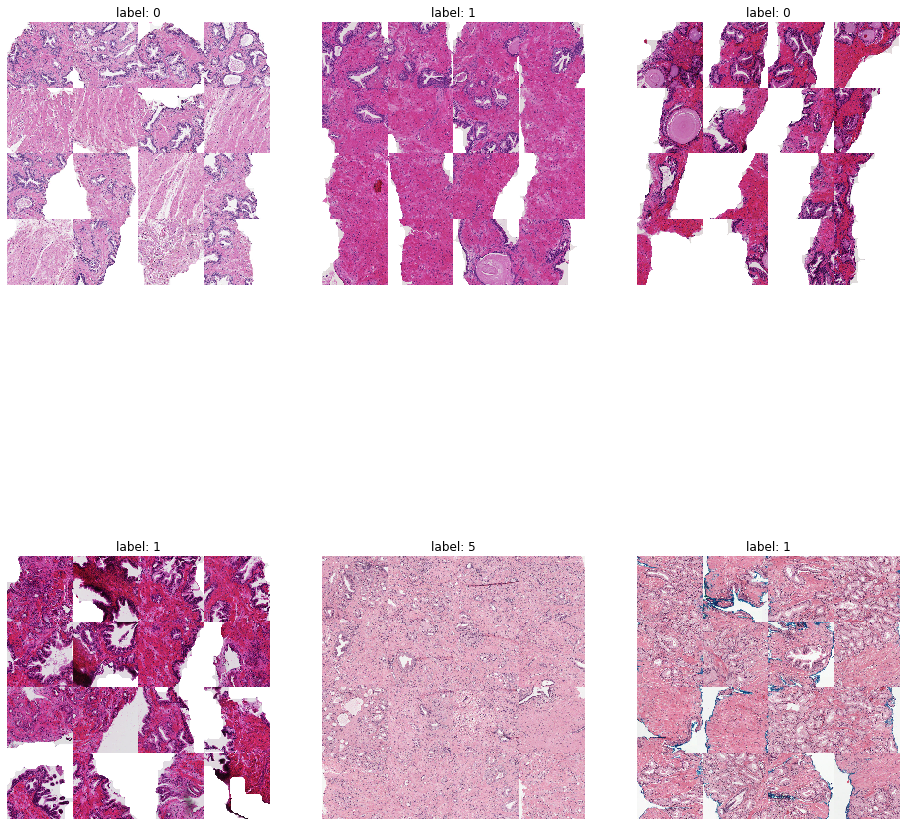

In [10]:
val_data.display_batch(plot_grid=(2,3))

## Keras method
The intended use of this notebook is to import fully completed models on the fly, and then wrapping them into a Network class in the models folder, but this is not done yet, so the routine is explained here for tiling.   

Since we are using tiling, we have to do some reshaping, including the batch size (at least if we want to use pretrained models). For this, the reshape in the Keras backend module has to be used. The tiles are temporarily transported to the batch dimension, at which point it is reshaped back into the normal shape just before pooling and classification/regression.

In [10]:
def qwk_act(x):
    x = K.switch(x>=0, x, 0)
    x = K.switch(x <=5, x, 5)
    return x

In [11]:
lbl_value_counts = train_df['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
print('classes weigths:', class_weights)

classes weigths: {0: 1.0, 1: 1.142550911039657, 2: 2.260869565217391, 4: 2.4704519119351103, 3: 2.532066508313539, 5: 2.6031746031746033}


In [14]:
def build_model_img(row=1440, col=1440):
    bottleneck = efn.EfficientNetB1( 
        include_top=False, 
        pooling='avg',
        weights='imagenet',
        input_shape = (row, col, 3)
    )

    #ResNext50, _ = Classifiers.get('resnext50')
    #bottleneck = ResNext50(input_shape=(SZ, SZ, 3),
    #                       weights='imagenet', include_top=False)


    from tensorflow.keras import Sequential
    bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    model = Sequential()
    model.add(bottleneck)
    model.add(KL.BatchNormalization())
    model.add(KL.GlobalMaxPooling2D())
    model.add(KL.Flatten())
    model.add(KL.BatchNormalization())
    model.add(KL.Dropout(.25))
    model.add(KL.Dense(512, activation='elu'))
    model.add(KL.BatchNormalization())
    model.add(KL.Dropout(.25))
    model.add(KL.Dense(1, activation=qwk_act, dtype='float32'))
    return model

model = build_model_img(1440, 1440)

In [15]:

def build_model_tile(NUM_TILES, SZ)
    bottleneck = efn.EfficientNetB1( 
        include_top=False, 
        pooling='avg',
        weights='imagenet'
    )

    #ResNext50, _ = Classifiers.get('resnext50')
    #bottleneck = ResNext50(input_shape=(SZ, SZ, 3),
    #                       weights='imagenet', include_top=False)


    from tensorflow.keras import Sequential
    bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
    model = Sequential()
    model.add(KL.TimeDistributed(bottleneck, input_shape=(NUM_TILES, SZ, SZ, 3)))
    model.add(KL.TimeDistributed(KL.BatchNormalization()))
    model.add(KL.TimeDistributed(KL.GlobalMaxPooling2D()))
    model.add(KL.Flatten())
    model.add(KL.BatchNormalization())
    model.add(KL.Dropout(.25))
    model.add(KL.Dense(512, activation='elu'))
    model.add(KL.BatchNormalization())
    model.add(KL.Dropout(.25))
    model.add(KL.Dense(1, activation=qwk_act, dtype='float32'))
    return model

In [18]:
bottleneck = efn.EfficientNetB1( 
    include_top=False, 
    pooling='avg',
    weights='imagenet'
)



In [16]:
bottleneck.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 45, 45, 1280)      6575232   
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 45, 1280)      5120      
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               6

In [24]:
!nvidia-smi


Mon Jun  8 15:21:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           On   | 00000000:04:00.0 Off |                    0 |
| N/A   35C    P0    59W / 250W |    538MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           On   | 00000000:82:00.0 Off |                    0 |
| N/A   35C    P0    61W / 250W |    111MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [25]:
optimizer = Adam(lr=1e-4)

# wrap the Keras.Optimizer with gradient accumulation of 2 steps

lrreducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=.1,
    patience=4,
    verbose=1,
    min_lr=1e-7
)

# custom callbacks
custom_callbacks = [lrreducer]

# qwk is added by default in network class
custom_metrics = [tf.keras.metrics.RootMeanSquaredError()]
custom_loss = tf.keras.losses.MeanSquaredError()

In [26]:
network = Network(model)


In [27]:
network.train(dataset=data(),
              val_dataset=val_data(mode='validation'),
              epochs=NUM_EPOCHS,
              learning_rate=LEARNING_RATE,
              num_classes=NUM_CLASSES,
              sparse_labels=True,
              regression=True,
              custom_callbacks=custom_callbacks,
              custom_metrics=custom_metrics,
              custom_loss=custom_loss,
              custom_optimizer=optimizer,
              save_weights_name='notebooks_test.h5',
              tb_logdir="./logs4")

Epoch 1/15
2488/2488 [==============================] - ETA: 0s - loss: 3.9756 - cohen_kappa: 0.3019 - root_mean_squared_error: 1.9939
Epoch 00001: val_cohen_kappa improved from -inf to 0.52274, saving model to notebooks_test_bestQWK.h5
2488/2488 [==============================] - 2604s 1s/step - loss: 3.9756 - cohen_kappa: 0.3019 - root_mean_squared_error: 1.9939 - val_loss: 2.7912 - val_cohen_kappa: 0.5227 - val_root_mean_squared_error: 1.6707 - lr: 1.0000e-04
Epoch 2/15
2488/2488 [==============================] - ETA: 0s - loss: 3.3460 - cohen_kappa: 0.3874 - root_mean_squared_error: 1.8292
Epoch 00002: val_cohen_kappa improved from 0.52274 to 0.60034, saving model to notebooks_test_bestQWK.h5
2488/2488 [==============================] - 2596s 1s/step - loss: 3.3460 - cohen_kappa: 0.3874 - root_mean_squared_error: 1.8292 - val_loss: 2.4840 - val_cohen_kappa: 0.6003 - val_root_mean_squared_error: 1.5761 - lr: 1.0000e-04
Epoch 3/15
 192/2488 [=>............................] - ETA: 36

KeyboardInterrupt: 

In [23]:
#network.load_weights('../EfficientNetB1_1_20200607-155600_0_bestLoss.h5')

In [24]:
for x,y in val_data(mode='validation').take(20):
    print(network.predict(x), y.numpy())

[[1.8596858]
 [2.802034 ]] [0 1]
[[1.6649345]
 [2.6350842]] [0 1]
[[1.8287089]
 [2.2895145]] [5 1]
[[1.9825944]
 [2.263229 ]] [2 5]
[[2.6797   ]
 [1.6136218]] [1 3]
[[2.3160863]
 [1.5972039]] [1 2]
[[3.1036482]
 [2.5695481]] [0 2]
[[2.9286814]
 [1.7390159]] [0 0]
[[2.1227386]
 [1.732349 ]] [3 0]
[[1.6980102]
 [1.9574171]] [4 1]
[[1.7023098]
 [2.2096443]] [1 3]
[[1.7892578]
 [1.8709775]] [1 5]
[[2.813745 ]
 [1.6641456]] [5 4]
[[2.100163 ]
 [1.6029801]] [4 1]
[[2.3161907]
 [2.943956 ]] [1 5]
[[2.0428352]
 [1.7009488]] [0 0]
[[1.9125718]
 [2.6107502]] [4 4]
[[2.0168042]
 [2.4877052]] [1 2]
[[1.8332878]
 [1.7947555]] [0 1]
[[1.6629936]
 [1.6466621]] [3 1]


In [28]:
for x,y in val_data(mode='validation').take(1):
    x = x.numpy()

In [20]:
del model
import gc
gc.collect()
K.clear_session()
from numba import cuda
cuda.select_device(0)
cuda.close()

## Quick experiences:

1. QWK cohenkappa of tensorflow addons is a stateful metric :)
2. SEED YOUR LAYERS!!!